# Imports

In [2]:
#!pip install tf2onnx
import os
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
from scipy.stats import qmc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib #to save Scalers
from sklearn.metrics import mean_squared_error
import seaborn as sns
from keras.models import Sequential, Model
from keras import Input
from keras.layers import Dense, Conv1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback
from keras import Loss
from keras.saving import register_keras_serializable
from keras.utils import split_dataset
from keras.preprocessing import timeseries_dataset_from_array
import keras
import tf2onnx
from src._utils.utils import load_yaml_file

PHYSICS_PARAMS = load_yaml_file("src/config.yml")["PHYSICS_PARAMS"]

2025-06-28 16:22:42.206101: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-28 16:22:42.214814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751124162.224926  105778 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751124162.228152  105778 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751124162.237929  105778 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Helper funcs

In [3]:
def comparison_plot(dt, true_data: np.ndarray,
                     pred_data: list[tuple[np.ndarray, str]], suptitle: str,
                     meas_data: np.ndarray = None):
    '''
    true_data: contains acc, vel (in m/s), and pos in (t, 3) shape
    '''
    data, label = pred_data[0]
    t_end = (data.shape[0]-1)*dt
    t = np.arange(0, t_end+dt, dt)
    
    # Plot for acceleration:
    plt.figure()
    plt.plot(t, true_data[:, 0], label="True Acceleration", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 0], '--', label=label, linewidth=2)
    if meas_data is not None:
        plt.scatter(t, meas_data, label="Measured acceleration points", s=7, c='red')
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("Acceleration")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot for velocity:
    plt.figure()
    plt.plot(t, true_data[:, 1]*3.6, label="True Velocity", linewidth=2) #conversion from m/s to km/h
    for data, label in pred_data:
        plt.plot(t, data[:, 1]*3.6, '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot for position
    plt.figure()
    plt.plot(t, true_data[:, 2], label="True Position", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 2], '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history, es_start_epoch):
    loss = history["loss"]
    val_loss = history["val_loss"]
    best_epoch = es_start_epoch + np.argmin(val_loss[es_start_epoch:]) + 1

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss, label="Training Loss")
    plt.plot(range(1, len(loss) + 1), val_loss, label="Validation Loss (against ground truth)")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

    #add a marker for the early stopping epoch
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Restored')
    plt.text(best_epoch, val_loss[best_epoch - 1], f'({best_epoch}, {val_loss[best_epoch - 1]:.5e})',
             color='b', fontsize=12)

    plt.legend()
    plt.show()

def evaluate_results(pred_a, true_data, dt, scaler_Y=None):
    v = np.zeros_like(pred_a[:, 0])
    x = np.zeros_like(pred_a[:, 0])

    if scaler_Y:
        pred_a = scaler_Y.inverse_transform(pred_a).copy()

    v = cumulative_trapezoid(pred_a.flatten(), dx=dt, initial=0)
    v += true_data[0,1]
    x = cumulative_trapezoid(v, dx=dt, initial=0)
    x += true_data[0,2]

    mse_a = mean_squared_error(true_data[:,0], pred_a)
    mse_v = mean_squared_error(true_data[:,1], v)
    mse_x = mean_squared_error(true_data[:,2], x)

    v = v.reshape(-1, 1)
    x = x.reshape(-1, 1)

    pred_data = np.hstack((pred_a, v, x))

    print(f"MSE/RMSE for acceleration: {mse_a:.5e}, {np.sqrt(mse_a):.5e}")
    print(f"MSE/RMSE for velocity: {mse_v:.5e}, {np.sqrt(mse_v):.5e}")
    print(f"MSE/RMSE for position: {mse_x:.5e}, {np.sqrt(mse_x):.5e}")

    return pred_data

# Prepping data

## DEFINE HERE THE TRAINING SETUP

In [50]:
train_cycles = ["udds", "hwycol"] #* CHANGE HERE TRAINING DATA
val_cycles = ["nycccol"] #* CHANGE HERE VAL DATA
n_features = 3
print(f"Number of features: {n_features}")

train_dfs = []
for cycle in train_cycles:
    train_dfs.append(pd.read_csv("data/driving_cycles/CACC_" + cycle + ".csv"))
val_dfs = []
for cycle in val_cycles:
    val_dfs.append(pd.read_csv("data/driving_cycles/CACC_" + cycle + ".csv"))

print(f"Number of train driving cycles: {len(train_dfs)}")
dt = 0.1
print(f"dt: {dt}")
train_ratio = .7
print(f"Train/Val split: {train_ratio}")
window_size = 3
print(f"Window size: {window_size}")
batch_size = 32
print(f"Batch size: {batch_size}")

cycle_str = "_".join(train_cycles)
model_name = f"FC__{cycle_str}_{int(train_ratio*100)}%_windowsize{window_size}" #name to use for saves
print(model_name)

Number of features: 3
Number of train driving cycles: 2
dt: 0.1
Train/Val split: 0.7
Window size: 3
Batch size: 32
FC__udds_hwycol_70%_windowsize3


In [ ]:
def fit_scalers(dfs: list[pd.DataFrame]):
    X_list = [df[["t", "fv0_u", "fv0_v_noise"]].to_numpy() for df in dfs]
    Y_list = [df[["fv0_a_noise"]].to_numpy() for df in dfs]
    X_full = np.concatenate(X_list, axis=0)
    Y_full = np.concatenate(Y_list, axis=0)
    scaler_X = MinMaxScaler((-1,1)).fit(X_full)
    scaler_Y = StandardScaler().fit(Y_full)
    return scaler_X, scaler_Y

def create_dataset(dfs: list, scaler_X, scaler_Y, window_size) -> tf.data.Dataset:
    total_ds: tf.data.Dataset = None
    for df in dfs:
        X = df[["t", "fv0_u", "fv0_v_noise"]].to_numpy()
        Y = df[["fv0_a_noise"]].to_numpy()
        
        X_scaled  = scaler_X.transform(X)
        Y_scaled  = scaler_Y.transform(Y)

        padding = np.repeat(X_scaled[0:1, :], window_size-1, axis=0) #need to pad features (like in a real application until the buffer is filled)
        X_scaled_padded = np.concatenate([padding, X_scaled], axis=0)

        ds = timeseries_dataset_from_array(data=X_scaled_padded, targets=Y_scaled, sequence_length=window_size,
                                                   sequence_stride=1, batch_size=None, shuffle=False)
        ds = ds.map(lambda x, y: (tf.reshape(x, [-1]), y)) #flatten for dense layers: (None, window*features) 

        if total_ds == None: #first cycle
            total_ds = ds
        else: #next keep concatenating cycles. This prevents the boundary problem of concatenating the cycles beforehand
            total_ds = total_ds.concatenate(ds)
    return total_ds #combine feature and labels

In [55]:
cardinality = sum([df.shape[0] for df in train_dfs])
print("Full dataset cardinality: "+str(cardinality))
scaler_X, scaler_Y = fit_scalers(train_dfs)
joblib.dump(scaler_X, f"models/scalers/scalerX_{model_name}.save")
joblib.dump(scaler_Y, f"models/scalers/scalerY_{model_name}.save")
ds_train =  create_dataset(train_dfs, scaler_X, scaler_Y, window_size)

ds_val = create_dataset(val_dfs, scaler_X, scaler_Y, window_size)

ds_train = ds_train.shuffle(buffer_size=cardinality, seed=31, reshuffle_each_iteration=True) #shuffle per epoch
#Using buffer_size = cardinality, for uniform shuffling. Else it would affect the randomness

#test
print("Elements before batching:")
for element in ds_train.take(1):
    print(element)

ds_train = ds_train.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE) #activate caching after first epoch.
#Then, in parallel fetch another buffer_size elements while one is processing
ds_val = ds_val.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Full dataset cardinality: 21340
Elements before batching:
(<tf.Tensor: shape=(9,), dtype=float64, numpy=
array([-0.00504054, -0.04211081,  0.69221391, -0.00489444, -0.01561467,
        0.68817719, -0.00474834,  0.0429081 ,  0.68316044])>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.07772898])>)


# PUNN-only

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,025 (35.25 KB)

 Trainable params: 9,025 (35.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
667/667 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1564 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 2/2000
667/667 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0051 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 3/2000
667/667 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0035 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 4/2000
667/667 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0030 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 5/2000
667/667 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 6/2000
667/667 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 7/2000
667/667 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0022 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 8/2000
667/667 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0022 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 9/2000
667/667 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0021 - val_loss: 0.0018 - learning_rate:

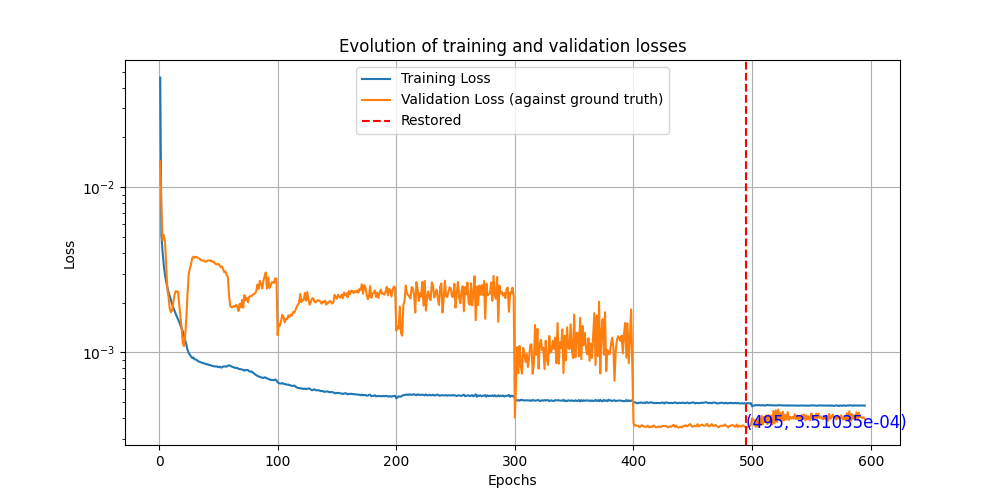

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 4.3921e-04


0.0003510345995891839

In [59]:
#globals
#------
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 2000
patience = 100
start_from_epoch = 200
loss = "mse"
metrics = []
schedule_tg = 100
opt = Adam(learning_rate=1e-3, weight_decay=1e-2)
#------

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)
def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath=f'models/punn_{model_name}.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#PUNN
inputs = Input(shape=(window_size*n_features, )) #_ for batch dim
x = inputs
for _ in range(0,n_hid_layers):
    #punn_model.add(Dense(n_neurons, activation=act))
    x = Dense(n_neurons, activation='tanh')(x)
outputs = Dense(1, activation="linear")(x) #output layer -> a^
punn_model = Model(inputs=inputs, outputs=outputs)
punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
punn_model.summary()

history_punn_fwd = punn_model.fit(x=ds_train, validation_data=ds_val, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_punn_fwd.history, start_from_epoch)
punn_model.evaluate(x=ds_val) #just to confirm final validation loss

# PINN

## Combined Loss

In [60]:
# collocation points
collocation_size = 10000
print("Number of collocation points: " + str(collocation_size))
#dimension size -> ["t", "fv0_u", "fv0_v", "d_fv0_lv", "d*_fv0_lv", "lv_v"]
sampler = qmc.LatinHypercube(d=n_features)
collocation = sampler.random(n=collocation_size)
print(qmc.discrepancy(collocation)) #evaluate sampling distribution
u_min = PHYSICS_PARAMS["a_min"]*PHYSICS_PARAMS["m"]
u_max = PHYSICS_PARAMS["a_max"]*PHYSICS_PARAMS["m"]
v_max = PHYSICS_PARAMS["v_max"]
t_max = collocation_size
l_bounds = [0, u_min, 0.0]
u_bounds = [t_max, u_max, v_max]
print(l_bounds)
print(u_bounds)
X_c = qmc.scale(collocation, l_bounds=l_bounds, u_bounds=u_bounds).astype(np.float32)
pd.DataFrame(X_c).to_csv("data/collocation_data.csv")

Number of collocation points: 10000
1.008157608994864e-05
[0, -10272.0, 0.0]
[10000, 5403.072, 38.888]


In [83]:
@register_keras_serializable()
class PinnModel(Model):
    def __init__(self, true_phy_params, train_params,
                 n_hid_layers, n_neurons=64, act="tanh", **kwargs):
        super().__init__(**kwargs)
        self.true_params  = true_phy_params
        self.train_params = train_params
        self.n_hid_layers = n_hid_layers
        self.n_neurons = n_neurons
        self.act = act

        #Architecture
        self.hidden_layers = [
            Dense(self.n_neurons, activation='tanh', name=f"dense{i}")
            for i in range(n_hid_layers)
        ]
        self.out_layer = Dense(1, activation="linear")

        #physics setup
        for key, value in self.true_params.items():
            is_trainable = key in self.train_params.keys()
            if is_trainable:
                #use provided initial estimation
                initial_value = self.train_params[key]
            else:
                #use true value
                initial_value = value

            weight = self.add_weight(
                    name=key,
                    shape=(),
                    initializer=keras.initializers.Constant(initial_value),
                    trainable=is_trainable,
                    dtype=tf.float32
                )
            self.__setattr__(key, weight) #set as attibute for serialization
        #helper dict
        self.params = { k: self.__getattribute__(k) for k in self.true_params.keys()}
            
    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.out_layer(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "true_phy_params": self.true_params,
            "train_params": self.train_params,
            "n_hid_layers": self.n_hid_layers,
            "n_neurons": self.n_neurons,
            "act": self.act,
        })
        return config

class CombinedLoss(Loss):
    def __init__(self, model: Model, X_c: np.ndarray,
                 scaler_X, scaler_Y, alpha: float, window_size: int):
        
        '''
        Assumes u feature in second column of X_c provided and v in third.
        '''
        super().__init__()

        self.model = model
        self.alpha_d = alpha  #dictates data/physics ratio
        self.alpha_p = 1-alpha
        self.scaler_X = scaler_X
        self.scaler_Y = scaler_Y
        self.window_size = window_size
    
        self.u_phy = tf.constant(X_c[:, 1])
        self.v_phy = tf.constant(X_c[:, 2])

        X_c_norm = scaler_X.transform(X_c)
        X_c_norm_wind = tf.expand_dims(X_c_norm, axis=1) #now shape = (-1, 1, feat)
        #collocation states are not sequential so need to create a window with the same element throughout:
        X_c_norm_wind = tf.constant(tf.tile(X_c_norm_wind, [1, window_size, 1]), dtype=tf.float32)
        self.X_c_norm_flat = tf.reshape(X_c_norm_wind, shape=(-1, window_size*X_c_norm_wind.shape[2]))
        
    def data_loss(self, y_true, y_pred):
        sqr_diff = tf.square(y_true - y_pred)
        return tf.reduce_mean(sqr_diff)

    def physics_loss(self):
        g = self.model.g
        c0 = self.model.c0
        c1 = self.model.c1
        Cd = self.model.Cd
        m = self.model.m
        p = self.model.p
        Af = self.model.Af
        road_grade = self.model.road_grade

        a_norm = self.model(self.X_c_norm_flat) #use PUNN to predict on collocation points
        a_norm = tf.reshape(a_norm, shape=([-1])) #flatten for shape matching
        a_phy = a_norm * self.scaler_Y.scale_ + self.scaler_Y.mean_ #denormalize

        #resistive forces
        Fr = (c0 + c1 * self.v_phy) * (m*g*tf.math.cos(road_grade))
        Fa = (p * Cd * Af * self.v_phy**2) / 2.0
        Fg = m *g*tf.math.sin(road_grade)

        #physics residuals
        flow = (self.u_phy - Fr - Fa - Fg)/m
        res = a_phy - flow  # Newton's law

        return tf.reduce_mean(tf.square(res))

    def call(self, y_true, y_pred):
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()

        return(
            self.alpha_d * data_loss +
            self.alpha_p * pde_loss
        )

## Training

In [ ]:
#globals
#------
n_hid_layers = 3
n_neurons = 64
kernel_size = 3
act = "tanh"
epochs = 2000
patience = 100
start_from_epoch = 200
schedule_tg = 100
metrics = ["mse"]
opt = Adam(learning_rate=1e-4, weight_decay=1e-2)
alpha = 0.5 #physics weight = 1-alpha
#don't think boundary loss is needed when providing the states directly,
# as they serve as x0 -> a hard constraint for initial condition at each time step
true_phy_params = { #copied from above
    #*constant
    "g": PHYSICS_PARAMS["g"],
    "m": PHYSICS_PARAMS["m"],
    # https://en.wikipedia.org/wiki/Automobile_drag_coefficient
    "Af": PHYSICS_PARAMS["Af"], 
    "Cd": PHYSICS_PARAMS["Cd"],
    #*variable
    #rolling resistance:
    "c0": PHYSICS_PARAMS["c0"],
    "c1": PHYSICS_PARAMS["c1"],
    "p": PHYSICS_PARAMS["p"], #average air density
    "road_grade": PHYSICS_PARAMS["road_grade"]
}
#train_params = {"m": 1000, "Af": 2.5, "Cd": 0.2} #if joint training provide initial values
train_params = {}
#------

pinn_model = PinnModel(true_phy_params, train_params, n_hid_layers, n_neurons=n_neurons, act=act) #default kernel size = 3
#force build with dummy input
_ = pinn_model(tf.zeros((batch_size, window_size*n_features)))

#Custom PINN loss
loss = CombinedLoss(model=pinn_model, X_c=X_c, scaler_X=scaler_X, scaler_Y=scaler_Y, alpha=alpha, window_size=window_size)
pinn_model.build(input_shape=(None, window_size*n_features)) #none -> batch dim
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)

def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath=f'models/pinn_{model_name}.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

class CustomWeightLog(Callback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        if len(self.model.train_params) > 0: #if joint training
          for key, value in self.model.params.items():
              logs[key] = value
    def on_train_end(self, logs=None):
        print(f"Custom trainable weights converged to:")
        for key in self.model.train_params: #in trainable params list
            value = self.model.params[key]
            true_value = self.model.true_params[key]
            percentage = abs((value-true_value)/true_value)*100
            print(f"{key} = {value.numpy():.5e}, true value = {true_value} ({percentage:.3f}% difference)")

custom_weight_logger = CustomWeightLog()

callbacks = [early_stopping, lr_scheduler, checkpoint, custom_weight_logger]
#callbacks = [lr_scheduler, checkpoint, custom_weight_logger] #removed ES

#training
history_pinn_fwd = pinn_model.fit(x=ds_train, validation_data=ds_val, epochs=epochs,
                                  callbacks=callbacks)
loss_plot(history_pinn_fwd.history, start_from_epoch)
pinn_model.summary()

Epoch 1/2000


# PUNN vs PINN (TESTING)

In [95]:
test_traj = "us06col"
scaler_X = joblib.load(f"models/scalers/scalerX_{model_name}.save")
scaler_Y = joblib.load(f"models/scalers/scalerY_{model_name}.save")
df_test = pd.read_csv("data/driving_cycles/CACC_" + test_traj + ".csv")

X_test = df_test[["t", "fv0_u", "fv0_v_noise"]].to_numpy()
padding = np.repeat(X_test[0:1, :], window_size-1, axis=0) #need to pad features (like in a real application until the buffer is filled)
X_test = np.vstack([padding, X_test])
X_test_norm = scaler_X.transform(X_test)
ds_X_test = tf.data.Dataset.from_tensor_slices(X_test_norm)
ds_X_test = ds_X_test.window(size=window_size, shift=1, drop_remainder=True).flat_map(lambda window:window.batch(window_size))
ds_X_test = ds_X_test.map(lambda x: tf.reshape(x, [-1]))
ds_X_test = ds_X_test.batch(batch_size=1)
true_data = df_test[["fv0_a", "fv0_v", "fv0_x"]].to_numpy()


for x in ds_X_test.take(2):
    print("Sample test window (scaled):", x)
print("First few true_data rows:", true_data[:2])

Sample test window (scaled): tf.Tensor(
[[-1.          0.99287894 -0.99195377 -1.          0.99287894 -0.99195377
  -1.          0.99287894 -0.99195377]], shape=(1, 9), dtype=float64)
Sample test window (scaled): tf.Tensor(
[[-1.          0.99287894 -0.99195377 -1.          0.99287894 -0.99195377
  -0.9998539   0.99308799 -0.96115316]], shape=(1, 9), dtype=float64)
First few true_data rows: [[  4.208     0.      -20.     ]
 [  4.208     0.4208  -19.97896]]


Testing trajectory (us06col) statistics: 
PUNN:
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 3s 520us/step


/home/josearteaga/Desktop/tese/PINN-control-platooning/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


MSE/RMSE for acceleration: 2.28705e-04, 1.51230e-02
MSE/RMSE for velocity: 5.00039e+03, 7.07135e+01
MSE/RMSE for position: 3.17982e+08, 1.78320e+04
----
PINN:
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 3s 515us/step


/home/josearteaga/Desktop/tese/PINN-control-platooning/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


MSE/RMSE for acceleration: 9.50184e-01, 9.74774e-01
MSE/RMSE for velocity: 1.30233e+03, 3.60878e+01
MSE/RMSE for position: 9.16333e+07, 9.57253e+03


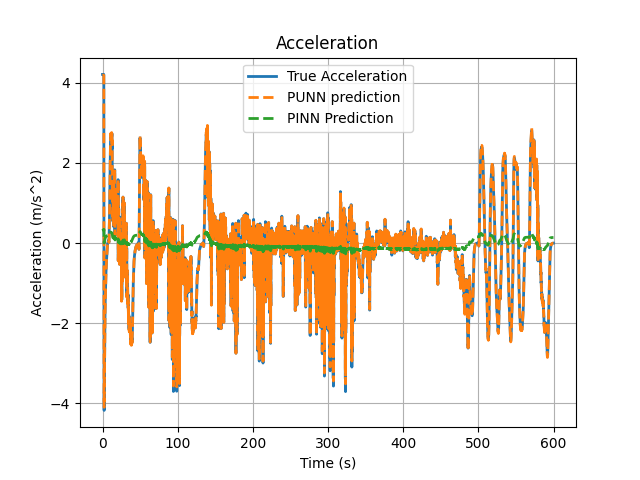

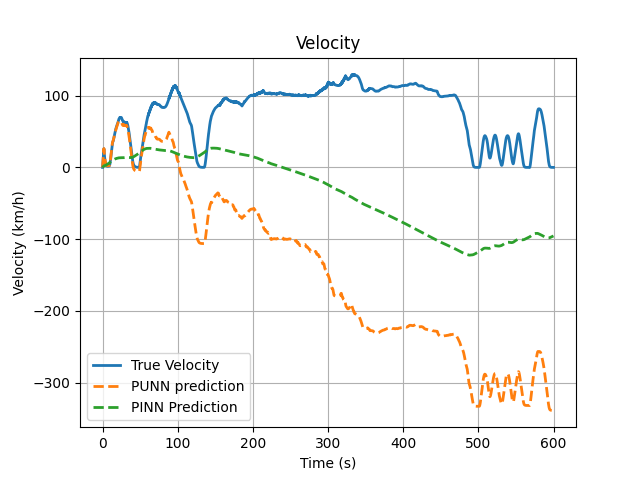

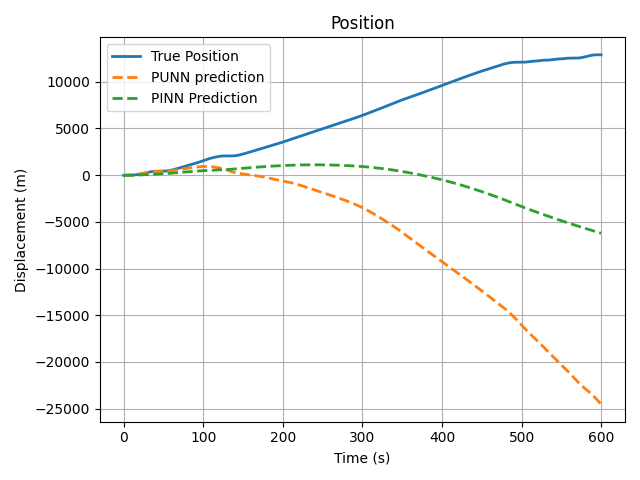

In [ ]:
punn_model = load_model(f"models/punn_{model_name}.keras", compile=True)
#punn_model.evaluate(ds_val) double check validation loss
#Load custom pinn model

#! NOT WORKING...
#custom_objects = {"PinnModel": PinnModel}#, "train_params": train_params, "true_phy_params": true_phy_params}
#pinn_model = load_model(f"models/pinn_{model_name}.keras", custom_objects=custom_objects, compile=False)

print("Testing trajectory (" + test_traj + ") statistics: ")
print("PUNN:")
punn_test_norm = punn_model.predict(ds_X_test)
punn_pred_avp = evaluate_results(punn_test_norm, true_data, dt, scaler_Y)
print("----")
print("PINN:")
pinn_test_norm = pinn_model.predict(ds_X_test)
pinn_pred_avp = evaluate_results(pinn_test_norm, true_data, dt, scaler_Y)

comparison_plot(dt, true_data=true_data, meas_data=None,
    pred_data=[(punn_pred_avp, "PUNN prediction"), (pinn_pred_avp, "PINN Prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN vs PINN for trajectory " + test_traj
)

# Convert to ONNX

In [99]:
custom_objects = {"PinnModel": PinnModel}
model = load_model(f"models/pinn_{model_name}.keras", custom_objects=custom_objects, compile=False)
input_shape = (None, window_size*n_features)
print("***Loading model...", f"Input shape = {input_shape}")
model_input_signature = [
    tf.TensorSpec(shape=input_shape, dtype=tf.float32, name='input'),
]
model.output_names = ['output'] #had to add this to prevent error. I think its because model hasnt been called yet
onnx_model, _ = tf2onnx.convert.from_keras(model,
    output_path=f'models/onnx/pinn_{model_name}.onnx',
    input_signature=model_input_signature,
)

***Loading model... Input shape = (None, 9)


I0000 00:00:1751220105.086717  105778 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1751220105.086909  105778 single_machine.cc:374] Starting new session
I0000 00:00:1751220105.094068  105778 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5758 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1751220105.119298  105778 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5758 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1751220105.122506  105778 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1751220105.122586  105778 single_machine.cc:374] Starting new session
I0000 00:00:1751220105.128551  105778 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/devic